# Exercise 1

In this exercise we will implement a visualization technique based on:

```
Zeiler, Matthew D. and Fergus, Rob.
"Visualizing and Understanding Convolutional Networks" in ECCV 2014
http://arxiv.org/abs/1311.2901
```

We are interested in theinput occlusion technique. The main idea is to systematically cover parts of the input witha gray box and measure how much the output(classification score) changes at each location. The change is measured relatively to the actual (initial) prediction score of the trained model, given the same input. The intuition is that the rate of change in the output suggests the importance of the occluded region. Every square shown in the image was occludedonce and the rate of change of the classification (class sax, saxophone) was measured. 

This is shown as a simple heatmap on the right and superimposed on the image on the left. One can see that the actual saxophone is highly important for the image to be classified as sax, saxophone. Although the network was never told what to look at, it learned what part of the image makes it classify as saxophone, therefore, it learns a coarse localization of objects.

<img src="data/sax_heat.jpg">

## Load ResNet 18 model from torchvision. Make sure it is pretrained on ImageNet. https://pytorch.org/docs/stable/torchvision/models.html

In [1]:
import torchvision.models as models
import torch

resnet18 = models.resnet18(pretrained=True)


## Load and visualize input image with PIL.

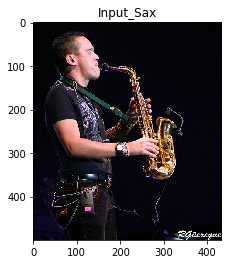

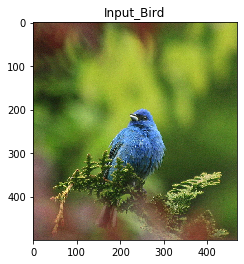

In [2]:
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

input_image = Image.open('data/sax.jpg')
input_image2 = Image.open('data/bird.jpg')

plt.imshow(input_image)
plt.title('Input_Sax')
plt.show()

plt.imshow(input_image2)
plt.title('Input_Bird')
plt.show()

## Preprocess the input image according to the original training. https://pytorch.org/docs/stable/torchvision/models.html

In [3]:
from torchvision import transforms

resize = transforms.Resize(256)
crop = transforms.CenterCrop(224)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
to_image = transforms.ToPILImage()

preprocessing = transforms.Compose([
    resize,
    crop,
    to_tensor,
    normalize
])

image = preprocessing(input_image)
image2 = preprocessing(input_image2)

# plt.imshow(to_image(image))
# plt.title('Normalized input sax image')
# plt.show()

# plt.imshow(to_image(image2))
# plt.title('Normalized input bird image')
# plt.show()

## Run the network on the full input and check the predicted class and probability.  Notice that the output is logits.

In [4]:
import numpy as np
import json

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum()

class_idx = json.load(open("data/imagenet_class_index.json"))

In [5]:
images = [image, image2]
probs = []
preds = []
num_img = 0
resnet18.eval()

for i in images:
    if len(i.size()) < 4:
        i = i.unsqueeze(0)

    output = resnet18(i)
    score = softmax(output)

    prob, pred = torch.max(score, 1)
    probs.append(prob)
    preds.append(pred)
    
    print("Image: sax.jpg" if num_img == 0 else "Image: bird.jpg")
    print("Probability: %.3f" % prob.detach().cpu().numpy()[0])
    print("Class: ", class_idx[str(pred.detach().cpu().numpy()[0])][1])
    print()
    
    num_img += 1


Image: sax.jpg
Probability: 0.998
Class:  sax

Image: bird.jpg
Probability: 0.997
Class:  indigo_bunting



## Iteratively drop squares of 32 x 32 and run the network. Save the change in probabilities for the class of interest in probs_image.

In [6]:
def occlude(occlusion_size, prob, pred_class, input_image, model):
    probs_image = np.zeros((256, 256), dtype=np.float32)
    gray = 128*np.ones((occlusion_size, occlusion_size), dtype=np.float32)
    
    if torch.is_tensor(prob) and torch.is_tensor(pred_class):
        original_prob, pred = prob.detach().cpu().numpy(), pred_class.detach().cpu().numpy()
    else:
        original_prob, pred = prob, pred_class

    model.eval()

    for x in range(0, probs_image.shape[0], occlusion_size):
        for y in range(0, probs_image.shape[1], occlusion_size):
            new_image = to_tensor(resize(input_image))
            new_image[:, x:x+occlusion_size, y:y+occlusion_size] = torch.from_numpy(gray)
            new_image = crop(to_image(new_image))
            new_image = normalize(to_tensor(new_image))

            output = resnet18(new_image.unsqueeze(0))
            new_class_score = softmax(output)[0, pred].detach().cpu().numpy()

            change = abs(original_prob - new_class_score)/original_prob

            probs_image[x:x+occlusion_size, y:y+occlusion_size] = change
    
    probs_image *= 1.0/probs_image.max()

    return probs_image

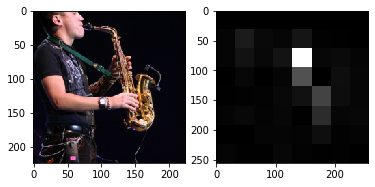

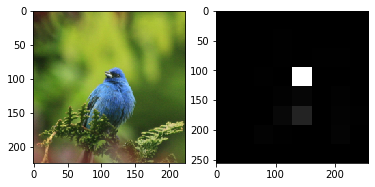

In [7]:
input_images = [input_image, input_image2]
num_imgs = 2
probs_change = []

for i in range(num_imgs):
    probs_change.append(occlude(32, probs[i], preds[i], input_images[i], resnet18))
    
    plt.subplot(1, 2, 1)
    plt.imshow(crop(resize(input_images[i])))
    
    plt.subplot(1, 2, 2)
    plt.imshow(probs_change[i], cmap="gray")
    
    plt.show()

## Sumperimpose the heatmap on the image and plot the results as displayed on the top.  

In [8]:
# This function generates a colored heatmap from the input
def heatmap(input, min=None, max=None):
    """ Returns a RGB heatmap representation """
    if min is None:
        min = np.amin(input)
    if max is None:
        max = np.amax(input)
    rescaled = 255 * ((input - min) / (max - min + 0.001))
    final = cv2.applyColorMap(rescaled.astype(np.uint8), cv2.COLORMAP_JET)
    return final.astype(np.float32) / 255

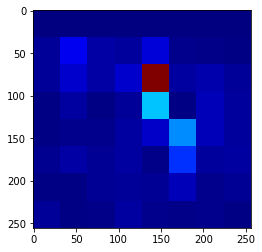

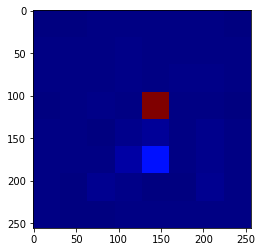

In [9]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

heatmaps = []

for i in range(len(probs_change)):
    heatmaps.append(heatmap(probs_change[i], 1, 0))
    plt.imshow(heatmaps[i])
    plt.show()

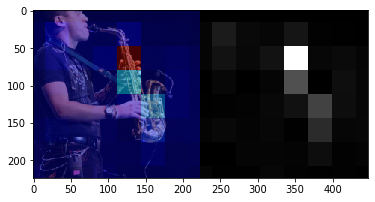

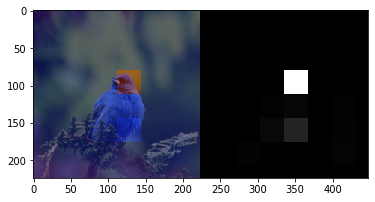

In [10]:
joined_images = []
for i in range(len(heatmaps)):
    in_image = np.array(crop(resize(input_images[i]))).astype(np.float32)
    added = cv2.addWeighted(in_image, 0.002, 
                            heatmaps[i][16:240, 16:240, :], 0.5, 0, -1)
    
    right_image = cv2.cvtColor(probs_change[i][16:240, 16:240], cv2.COLOR_GRAY2BGR).astype(np.float32)
    
    joined_images.append(np.concatenate((added, right_image), axis=1).astype(np.float32))

    plt.imshow(joined_images[i])
    plt.show()

plt.imsave("data/sax_heat.jpg", joined_images[0])
plt.imsave("data/bird_heat.jpg", joined_images[1])

#### 